In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

In [2]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

plt.style.use(['science'])
plt.style.reload_library()

In [3]:
n_runs = 8
n_scenarios = 3

In [4]:
DATA_DIR = Path('../data/')

In [5]:
def load_summary(path):
    df = pd.read_csv(path)
    df = df.drop(columns='region')
    df['time_stamp'] = pd.to_datetime(df['time_stamp'])
    df = df.groupby('time_stamp').sum().iloc[1:] # Avoid seeding day
    # Do 3 three days average to smoothen
    df['cum_deaths'] = df['daily_deaths'].cumsum()
    df['cum_infections'] = df['daily_infected'].cumsum()
    return df.rolling(window='3D').mean()

In [6]:
def average_sumaries(summary_list):
    df_concat = pd.concat(summary_list)
    by_row_index = df_concat.groupby(df_concat.index)
    df_means = by_row_index.mean()
    df_std = by_row_index.std()   
    return df_means, df_std/np.sqrt(len(summary_list))

In [7]:
baselines = [
    load_summary(
        DATA_DIR / f'baselines/summary_{str(run).zfill(3)}.csv'
    ) for run in range(n_runs)
]
avg_baseline, std_baseline = average_sumaries(baselines)

In [8]:
over_16 = [
    load_summary(
        DATA_DIR / f'children_vaccination_threshold/summary_{str(run).zfill(3)}.csv'
    ) for run in range(0,n_runs*n_scenarios, n_scenarios)
]
avg_over_16, std_over_16 = average_sumaries(over_16)


In [9]:
over_12 = [
    load_summary(
        DATA_DIR / f'children_vaccination_threshold/summary_{str(run).zfill(3)}.csv'
    ) for run in range(1,n_runs*n_scenarios, n_scenarios)
]
avg_over_12, std_over_12 = average_sumaries(over_12)

In [10]:
over_0 = [
    load_summary(
        DATA_DIR / f'children_vaccination_threshold/summary_{str(run).zfill(3)}.csv'
    ) for run in range(2,n_runs*n_scenarios, n_scenarios)
]
avg_over_0, std_over_0 = average_sumaries(over_0)

In [11]:
def plot_df(avg_df, std_df,ax, field,label,alpha=0.3, color=None):
    if color is None:
        ax.fill_between(
            avg_df[field].index,
            avg_df[field] - std_df[field],
            avg_df[field] + std_df[field],
            alpha=alpha,
        )
        avg_df[field].plot(
            ax=ax, label=label, 
        )
    else:
        ax.fill_between(
            avg_df[field].index,
            avg_df[field] - std_df[field],
            avg_df[field] + std_df[field],
            alpha=alpha,
            color=color,
            edgecolor=None,
        )
        avg_df[field].plot(
            ax=ax, label=label, color=color,
        )

In [12]:
all_avg = [avg_baseline,avg_over_16, avg_over_12, avg_over_0]
all_std = [std_baseline, std_over_16,std_over_12, std_over_0]

labels = [r'BASELINE',#$> 18$ yo vaccinated',
          r'OLDER-TEENS',#$> 16$ yo vaccinated',
          r'MOST-TEENS',
          r'ALL-CHILDREN']

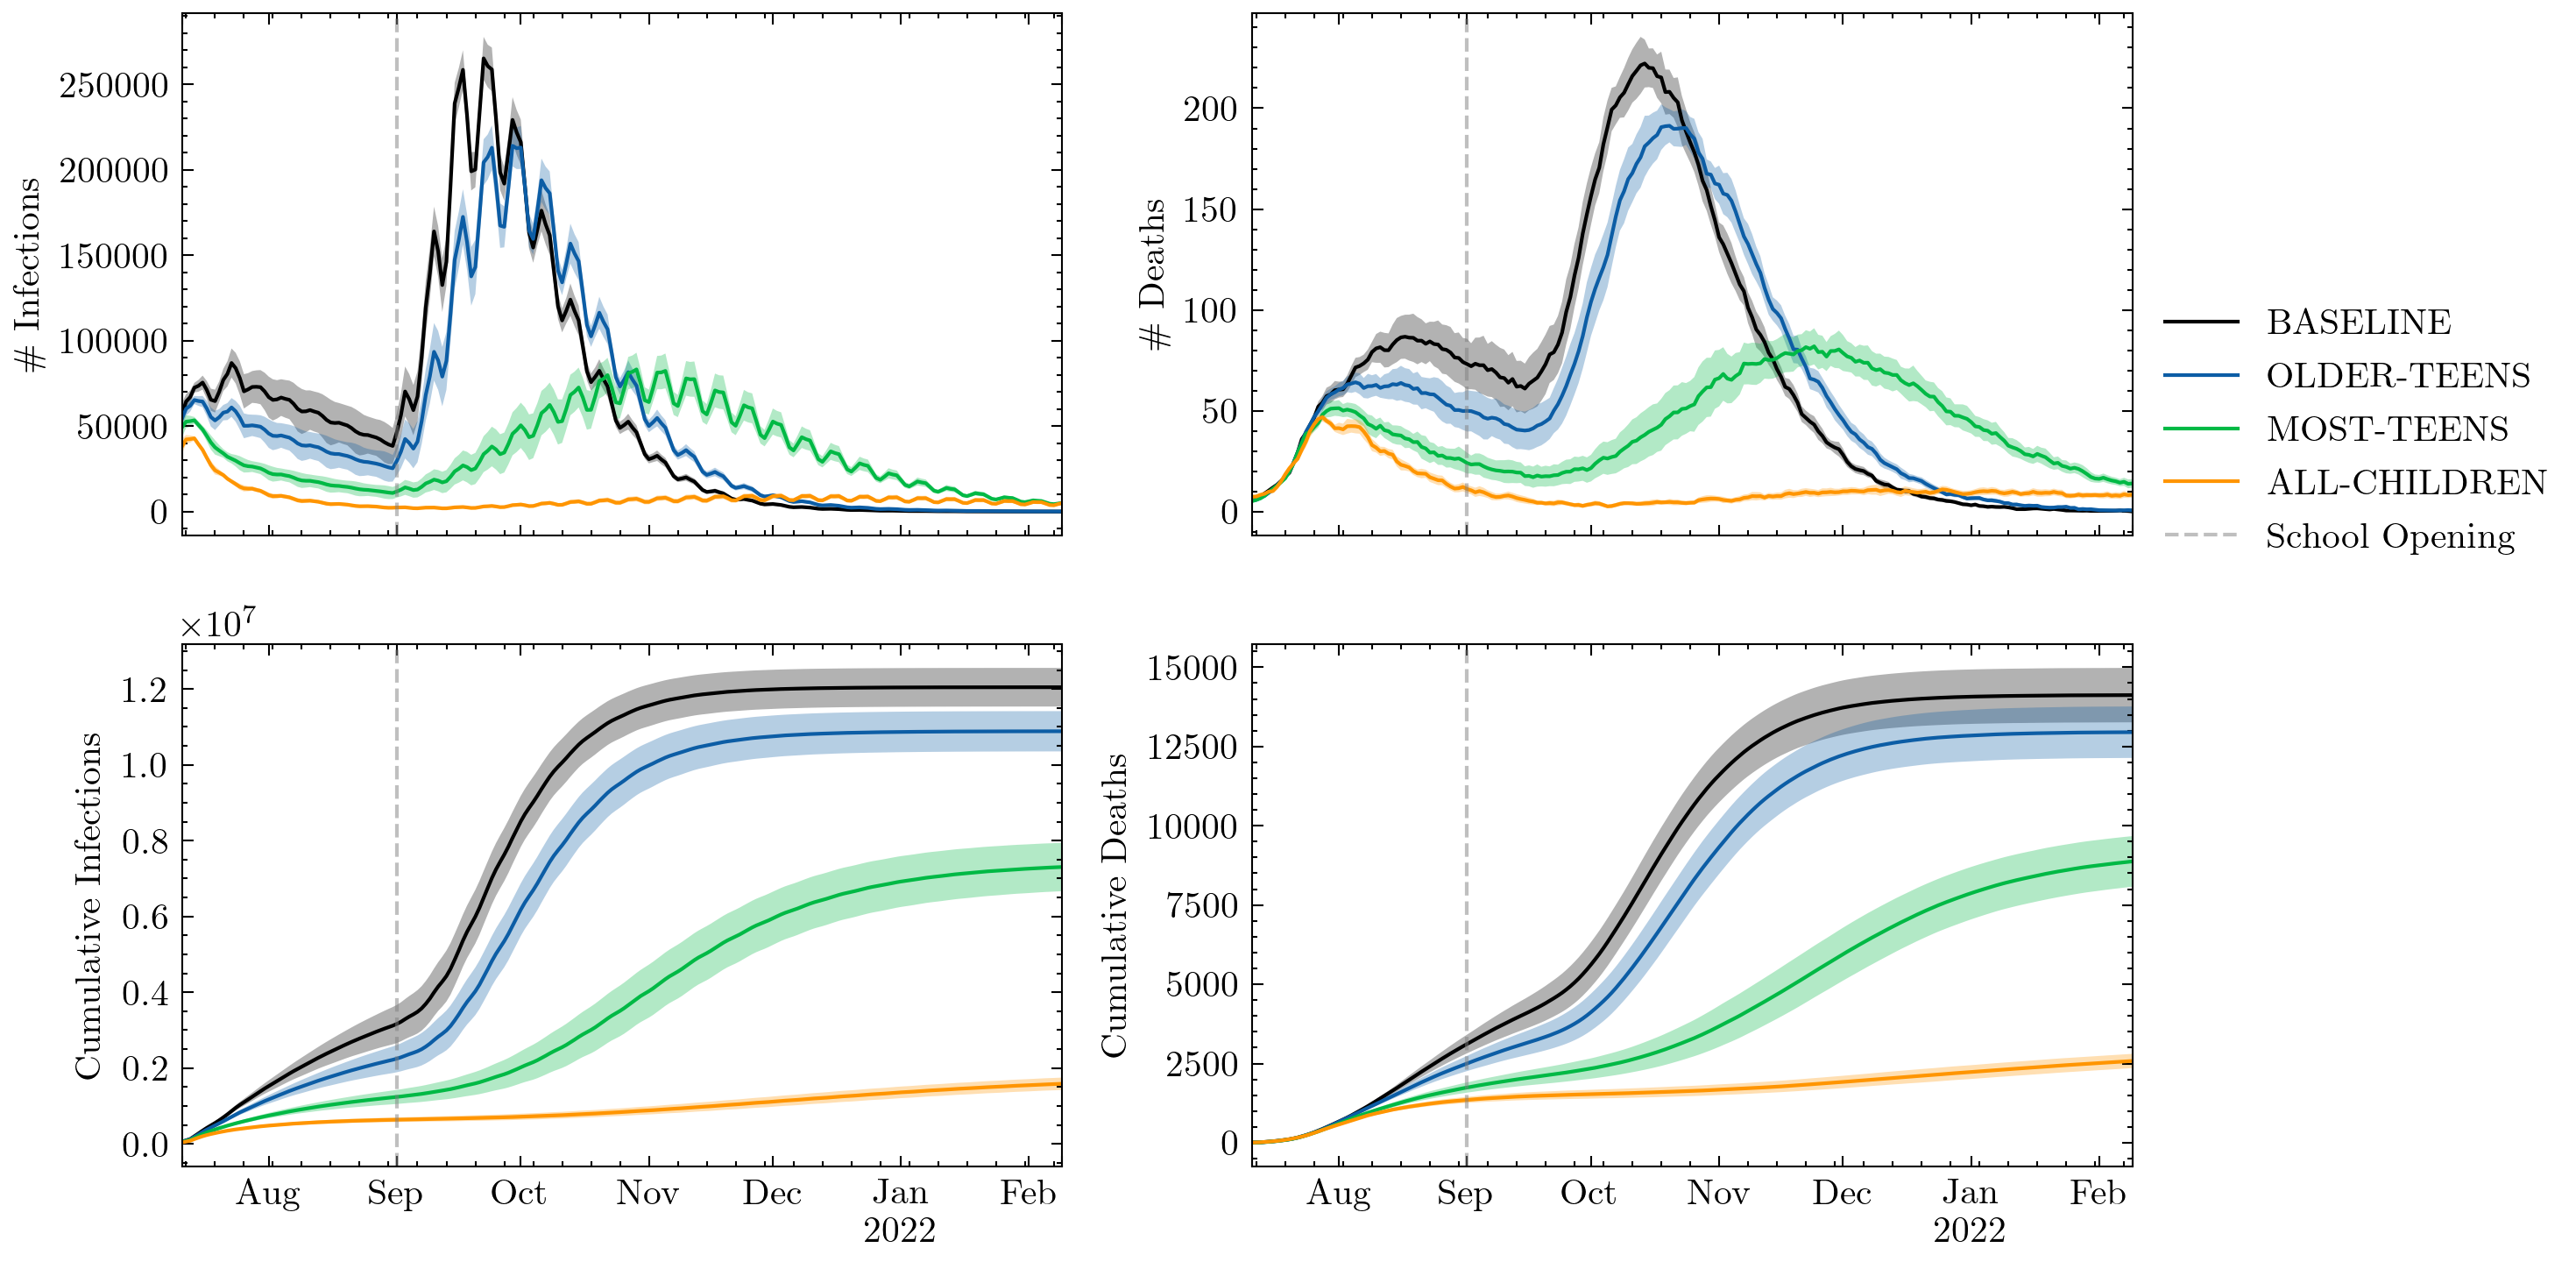

In [13]:
fig, ax = plt.subplots(ncols=2,nrows=2,figsize=(10,5),sharex=True)

#DAILY INFECTIONS
for i, (avg, std) in enumerate(zip(all_avg, all_std)):
    plot_df(avg,std,
        ax[0,0], 'daily_infected',
        label=labels[i],
        color='black' if i ==0 else None
    )

    
for i, (avg, std) in enumerate(zip(all_avg, all_std)):
    plot_df(avg,std,
        ax[0,1], 'daily_deaths',
        label=labels[i],
        color='black' if i ==0 else None
           )
    
for i, (avg, std) in enumerate(zip(all_avg, all_std)):
    plot_df(avg,std,
        ax[1,0], 'cum_infections',
        label=labels[i],
        color='black' if i ==0 else None
           )

    
for i, (avg, std) in enumerate(zip(all_avg, all_std)):
    plot_df(avg,std,
        ax[1,1], 'cum_deaths',
        label=labels[i],
        color='black' if i ==0 else None
           )
    
for i in range(2):
    for j in range(2):
        ax[i,j].axvline('2021-09-01', linestyle='dashed', color='gray',
                  label='School Opening', alpha=0.5)

ax[0,1].legend(bbox_to_anchor=(1,0.5))

ax[1,0].set_xlabel('')
ax[0,0].set_ylabel(r'\# Infections')
ax[0,1].set_ylabel(r'\# Deaths')
ax[1,1].set_xlabel('')
ax[1,0].set_ylabel('Cumulative Infections')
ax[1,1].set_ylabel('Cumulative Deaths')

plt.tight_layout()
plt.savefig('../figures/Fig1_school_vaccination_strategies.pdf')